<a href="https://colab.research.google.com/github/debanjan02/BreakHis/blob/master/raw/magnification_40x/BreakHis_40_octal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
from sklearn.cluster import KMeans, estimate_bandwidth, MeanShift
from glob import glob
import cv2
import fnmatch

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
x = np.load('/content/drive/My Drive/project/x_BreakHis_40.npy')
from google.colab import files
files.upload()
y = np.load('y_BreakHis_40.npy')

Saving y_BreakHis_40.npy to y_BreakHis_40.npy


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 101)
y_train = to_categorical(y_train, num_classes = 8)
y_valid = to_categorical(y_valid, num_classes = 8)

In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, LSTM, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU 
from keras.applications.inception_v3 import InceptionV3
input_tensor = Input(shape=(299,299,3))
base_model = InceptionV3(input_tensor = input_tensor, include_top = False, pooling = 'average')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(8, activation = 'softmax')(x)
model = Model(base_model.input,x)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint
mcp = ModelCheckpoint(filepath='/content/drive/My Drive/project/model_check_path_BreakHis_40_octal_inception_v3',
                      monitor="val_acc", 
                      save_best_only=True, 
                      save_weights_only=False)

hist = model.fit(x_train,y_train,batch_size = 32, epochs = 200, verbose=1,  validation_split=0.2)

Train on 3830 samples, validate on 958 samples
Epoch 1/200
3830/3830 [==============================] - 172s 45ms/step - loss: 1.1958 - acc: 0.5883 - val_loss: 2.3687 - val_acc: 0.3466
Epoch 2/200
3830/3830 [==============================] - 146s 38ms/step - loss: 0.6750 - acc: 0.7658 - val_loss: 1.8765 - val_acc: 0.5209
Epoch 3/200
3830/3830 [==============================] - 146s 38ms/step - loss: 0.4718 - acc: 0.8316 - val_loss: 1.3874 - val_acc: 0.6701
Epoch 4/200
3830/3830 [==============================] - 146s 38ms/step - loss: 0.3075 - acc: 0.8950 - val_loss: 3.6105 - val_acc: 0.2547
Epoch 5/200
3830/3830 [==============================] - 146s 38ms/step - loss: 0.3050 - acc: 0.8961 - val_loss: 1.6489 - val_acc: 0.5386
Epoch 6/200
3830/3830 [==============================] - 146s 38ms/step - loss: 0.1989 - acc: 0.9279 - val_loss: 0.8436 - val_acc: 0.7296
Epoch 7/200
3830/3830 [==============================] - 146s 38ms/step - loss: 0.1850 - acc: 0.9303 - val_loss: 3.0908 - val

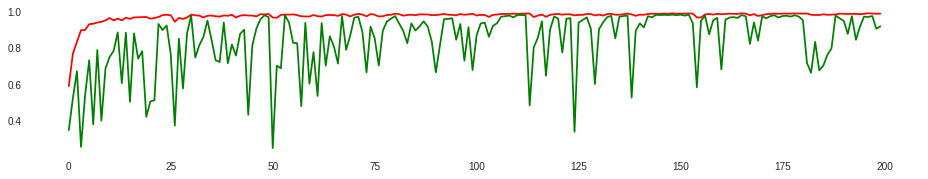

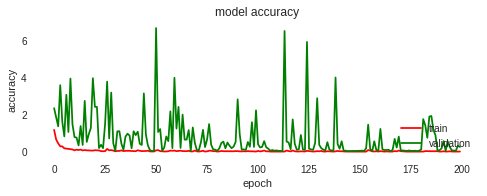

In [0]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(211)
ax1.set_facecolor('w')
ax1.grid(b=False)
ax1.plot(hist.history['acc'], color='red')
ax1.plot(hist.history['val_acc'], color ='green')
fig = plt.figure()
ax2 = fig.add_subplot(212)
ax2.set_facecolor('w')
ax2.grid(b=False)
ax2.plot(hist.history['loss'], color='red')
ax2.plot(hist.history['val_loss'], color ='green')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [0]:
model.load_weights('/content/drive/My Drive/project/model_check_path_BreakHis_40_octal_inception_v3')

OSError: ignored

In [0]:
from sklearn.metrics import classification_report
pred = model.predict(x_valid)
print(classification_report(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        74
           1       0.98      1.00      0.99       140
           2       0.97      1.00      0.99        66
           3       0.72      1.00      0.84        92
           4       0.97      0.89      0.92       523
           5       0.79      0.89      0.84        99
           6       1.00      0.91      0.95       118
           7       1.00      0.98      0.99        85

   micro avg       0.93      0.93      0.93      1197
   macro avg       0.92      0.96      0.94      1197
weighted avg       0.94      0.93      0.93      1197



In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.axis.grid = False
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

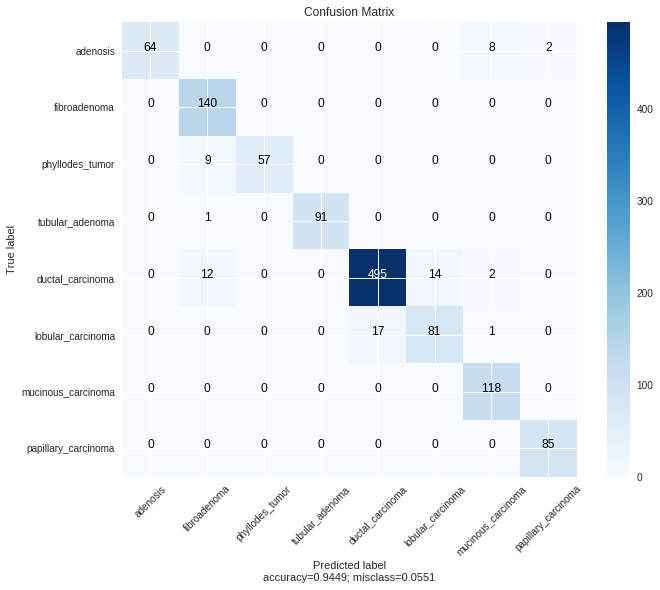

In [0]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_valid, axis = 1),np.argmax(pred, axis = 1))
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma', 'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma'],
                      title        = "Confusion Matrix")